# Tracing

Jun Wu

## Tracing Data

Example:

```
[-----span 1------] <- {"name": "span 1", "module": "a.py", "line": 30, ...}
  [--span 2--]      <- {"name": "span 2", "module": "b.rs", "line": 40, ...}
  ^          ^
  |          |
  |          {"action": "exit-span", .... }
  |
  {"action": "enter-span", "span": "span 2", "timestamp": 10, "tid": 2, ...}
```

Schema:

```rust
struct TracingData { spans: Vec<Span>, events: Vec<Event> }
struct Span        { meta: Map<String, String> }
struct Event       { action: Action, span_id: SpanId, time: Time, pid: u64, tid: u64 }
enum   Action      { EnterSpan, ExitSpan } 
```

Implementation:

```rust
struct TracingData { ..., strings: Vec<String> }
struct Span        { meta: Map<StringId, StringId> }
struct Event       { ... }
enum   Action      { ... }
```

## Tracing Integration

Rust, Python, Logging, Visualization

```
  +-------------+                                     +------------+
  |             |  tokio/tracing              Binary  |            |
  |  Rust Code  +-----------------+         +--------->  Blackbox  |
  |             |                 |         |         |            |
  +-------------+                 |         |         +------------+
                              +---v---------v--+
                              |                |
                              |  Tracing Data  |
                              |                |
                              +---^---------+--+
+---------------+                 |         |         +--------------+
|               |    bindings     |         |  JSON   |              |
|  Python Code  +-----------------+         +---------> Chrome Trace |
|               |                                     |              |
+---------------+                                     +--------------+
```

## Tracing in Rust

Proc-macro:

```rust
use tracing::instrument;

#[instrument]
fn plus0(a: u8, b: u8) -> u8 {
    a + b
}
```

```rust
#[instrument(level = "debug")]
fn plus1(a: u8, b: u8) -> u8 {
    a + b
}
```

Manual:


```rust
use tracing::info_span;

fn plus2(a: u8, b: u8) -> u8 {
   info_span!("plus2", a=a, b=b).in_scope(|| a + b)
}
```

```rust
fn plus3(a: u8, b: u8) -> u8 {
   let span = info_span!("plus3", a=a, b=b, result=0);
   let _guard = span.enter();
   let res = a + b;
   span.record("result", &res);
   res
}
```

## Tracing Overhead in Rust

By reading `tokio/tracing` source code:
- If a span is disabled, the overhead is a lock-free integer "eq" check (in one word: cheap).
- If a span is enabled, the overhead probably involves some locking, memory lookups / cache misses, etc (in one word: expensive).

Good practise: Use `info` for summary. Use `debug` for loop body.

```rust
fn download_files(urls: &[URL]) {
    info_span!("downloading files", count=urls.len()).in_scope(|| {
        urls.iter().for_each(download_single_file)
    })
}

fn download_single_file(url: &URL) {
    debug_span!("downloading file", url=url).in_scope(|| { ... })
}
```

Default trace level is `info`. To change trace level:

```bash
EDENSCM_TRACE_LEVEL=debug ./hg ...
```

## Tracing in Python

Decorator:

```python
from bindings import tracing

@tracing.wrapfunc
def plus1(a, b):
    return a + b
```

Decorator, with extra metadata:

```python
from bindings import tracing

@tracing.wrapfunc
@tracing.meta(lambda a, b: [("a", str(a)), ("b", str(b))])
def plus1(a, b):
    return a + b
```

Manual:

```python
from bindings import tracing

tracer = tracing.singleton

def plus2(a, b):
    spanid = tracer.span([("name", "plus2"), ("a", str(a)), ("b", str(b))])
    tracer.enter(spanid)
    result = a + b
    tracer.edit(spanid, [("result", str(result))])
    tracer.exit(spanid)
    return result
```

Note: No line number or module name recorded automatically.

## Tracing Overhead in Python

In [1]:
export CHGDISABLE=1

In [2]:
~/hg/hg debugpython << 'EOS'
from timeit import timeit
from bindings import tracing
def nop(): pass
@tracing.wrapfunc
def wrap(): pass
@tracing.wrapfunc
@tracing.meta(lambda: [("color", "blue")])
def wrap_meta(): pass
def bindings(tracer=tracing.singleton):
    id = tracer.span([("name", "bindings")]); tracer.enter(id); tracer.exit(id)
base = timeit(nop, number=10000)
for f in [nop, wrap, wrap_meta, bindings]:
    duration = timeit(f, number=10000)
    print("{:>6.1f}x {:>6.0f}ns  # {}".format(duration / base - 1, (duration - base) * 1e5, f.__name__))
EOS

   0.0x      0ns  # nop
   3.4x    266ns  # wrap
  12.9x    998ns  # wrap_meta
  24.5x   1895ns  # bindings


## Trace-Them-All as a Profiler

It could be affordable:

- `wrapfunc` has 300ns overhead per Python function call.
- A command like `hg sl` can take 1 second. It has 200k calls.
- If _all_ functions are wrapped, the overhead of `hg sl` is 60ms, or 6%.
- As a comparison, `import edenscm.mercurial.eden_dirstate` takes 50ms.

If some functions are not cheap to trace, we can blacklist them.

To trace functions in modules automatically (simplified):

```python
def tracemodule(mod):
    moddict = mod.__dict__
    for name, item in moddict.items():
        if callable(item):
            moddict[name] = tracing.wrapfunc(item)
```

To get a chance to trace modules at import time:

```python
# PEP 302: Import Hooks. Easier to use than `__import__`.
class ImportHook(object):
    def find_module(self, fullname):
        __import__(fullname)  # can also measure import overhead here
        tracemodule(sys.modules[fullname])
        ...

sys.meta_path.insert(0, ImportHook())
```

`edenscm.traceimport` added to handle automatic tracing. It is enabled right before `edenscm.hgdemandimport`. 

Python tracing can be turned on via `EDENSCM_TRACE_PY`:

```bash
EDENSCM_TRACE_PY='*' ./hg ...           # (attempt to) trace everything
EDENSCM_TRACE_PY='import' ...           # trace import overhead
EDENSCM_TRACE_PY='import edenscm.*' ... # trace imports, and edenscm modules
```

Wrapping happens at `import` time. The importer is changed at `edenscm.run`, before enabling `demandimport`.

## Python Profiler / Tracing Feature Matrix

|                      | statprof | traceprof | perftrace | tracing |
|----------------------|----------|-----------|-----------|---------|
| Profiler Overhead    | Low      | 14%       | -         | 6%      |
| High Precision       | No       | Yes       | Yes       | Yes     |
| Auto Instructment    | Yes      | Yes       | No        | Yes     |
| Include Line Numbers | Yes      | Yes       | No        | Yes     |
| Call Count           | **No**   | Yes       | Yes       | Yes     |
| Trace Rust Code      | No       | No        | No        | **Yes** |
| Trace Imports        | No       | No        | No        | Yes     |
| Metadata Annotations | No       | No        | Yes       | Yes     |
| Clean Traceback      | Yes      | Yes       | No        | Yes     |
| Trace Multi-threads  | No       | No        | No        | Yes     |
| Deserialization      | Yes      | No        | No        | Yes     |
| ASCII Visualizer     | Yes      | Yes       | Yes       | Yes     |
| Chrome Visualizer    | Yes      | No        | No        | Yes     |
| Merge Traces         | No       | No        | No        | Yes     |
| "No"s                | 7        | 7         | 9         | 0       |

# Output Formats

- ASCII
- Trace Event: `serde::Serialize` (which can be converted to JSON, CBOR, `PyObject`, etc.)
- Tree Spans: `serde::Serialize` (which can be converted to `PyObject`, etc.)

In [3]:
cat > ~/print << EOF
#!$HOME/hg/hg debugpython
import sys
from bindings import tracing

t = tracing.tracingdata()
with t:
    exec(sys.stdin.read())

if sys.argv[1] == 'ascii':
    min_micros = int(sys.argv[2])
    print(t.ascii(min_micros).strip())
elif sys.argv[1] == 'traceevent':
    import json
    print(json.dumps(t.traceevent(), sort_keys=True, indent=4, separators=(',', ': ')))
else:
    import pprint
    pprint.pprint(t.treespans())
EOF

chmod +x ~/print

## The ASCII Format

Accurate recursive call graph (like traceprof).

In [4]:
~/print ascii 0 << 'EOS'

@tracing.wrapfunc
def fib(x):
    return x if x <= 2 else fib(x - 1) + fib(x - 2)

fib(5)
EOS

Process 2366865 Thread 2366865:
Start Dur.ms | Name               Source
    0     +0 | __main__.fib       __main__ line 2
    0     +0  \ __main__.fib      __main__ line 2
    0     +0   \ __main__.fib     __main__ line 2
    0     +0    \ __main__.fib    __main__ line 2
    0     +0    \ __main__.fib    __main__ line 2
    0     +0   \ __main__.fib     __main__ line 2
    0     +0  \ __main__.fib      __main__ line 2
    0     +0   | __main__.fib     __main__ line 2
    0     +0   | __main__.fib     __main__ line 2


Annotated metadata (like perftrace)

In [5]:
~/print ascii 0 << 'EOS'

@tracing.wrapfunc
@tracing.meta(lambda x: [("x", str(x))])
def fib(x):
    return x if x <= 2 else fib(x - 1) + fib(x - 2)

fib(4)
EOS

Process 2366892 Thread 2366892:
Start Dur.ms | Name               Source
    0     +0 | __main__.fib       __main__ line 2
             | - x = 4            :
    0     +0  \ __main__.fib      __main__ line 2
               | - x = 3          :
    0     +0   \ __main__.fib     __main__ line 2
                | - x = 2         :
    0     +0   \ __main__.fib     __main__ line 2
                | - x = 1         :
    0     +0  \ __main__.fib      __main__ line 2
               | - x = 2          :


Call counts (like traceprof)

In [6]:
~/print ascii 50000 << 'EOS'
import time

sleep = tracing.wrapfunc(time.sleep)

for i in range(10):
    sleep(0.01)
EOS

Process 2366912 Thread 2366912:
Start Dur.ms | Name                  Source
    0   +101 | time.sleep (10 times) time line None


## The Tree Spans Format

Used internally by the ASCII render.

In [7]:
~/print treespans 0 << 'EOS'

@tracing.wrapfunc
def fact(x):
    return x if x <= 1 else x * fact(x - 1)

fact(2)
EOS

{(2366997, 2366997): [{'children': [1], 'duration': 0, 'start': 0},
                      {'children': [2],
                       'duration': 3,
                       'line': '2',
                       'module_path': '__main__',
                       'name': '__main__.fact',
                       'start': 137},
                      {'children': [],
                       'duration': 1,
                       'line': '2',
                       'module_path': '__main__',
                       'name': '__main__.fact',
                       'start': 138}]}


## The Trace Event Format

Format specification: https://github.com/catapult-project/catapult/wiki/Trace-Event-Format.

Supported By:
- Chrome `about:tracing`
- Chrome DevTools - Performance
- https://www.speedscope.app (might render incorrectly: https://github.com/jlfwong/speedscope/issues/223)

In [8]:
echo 'tracing.wrapfunc(id)(1)' | ~/print traceevent

{
    "displayTimeUnit": "ms",
    "otherData": {},
    "traceEvents": [
        {
            "args": {
                "line": "None",
                "module_path": "__builtin__"
            },
            "cat": "default",
            "name": "__builtin__.id",
            "ph": "B",
            "pid": 2366999,
            "tid": 2366999,
            "ts": 73
        },
        {
            "args": {
                "line": "None",
                "module_path": "__builtin__"
            },
            "cat": "default",
            "name": "__builtin__.id",
            "ph": "E",
            "pid": 2366999,
            "tid": 2366999,
            "ts": 74
        }
    ]
}


Chrome `about:tracing`:

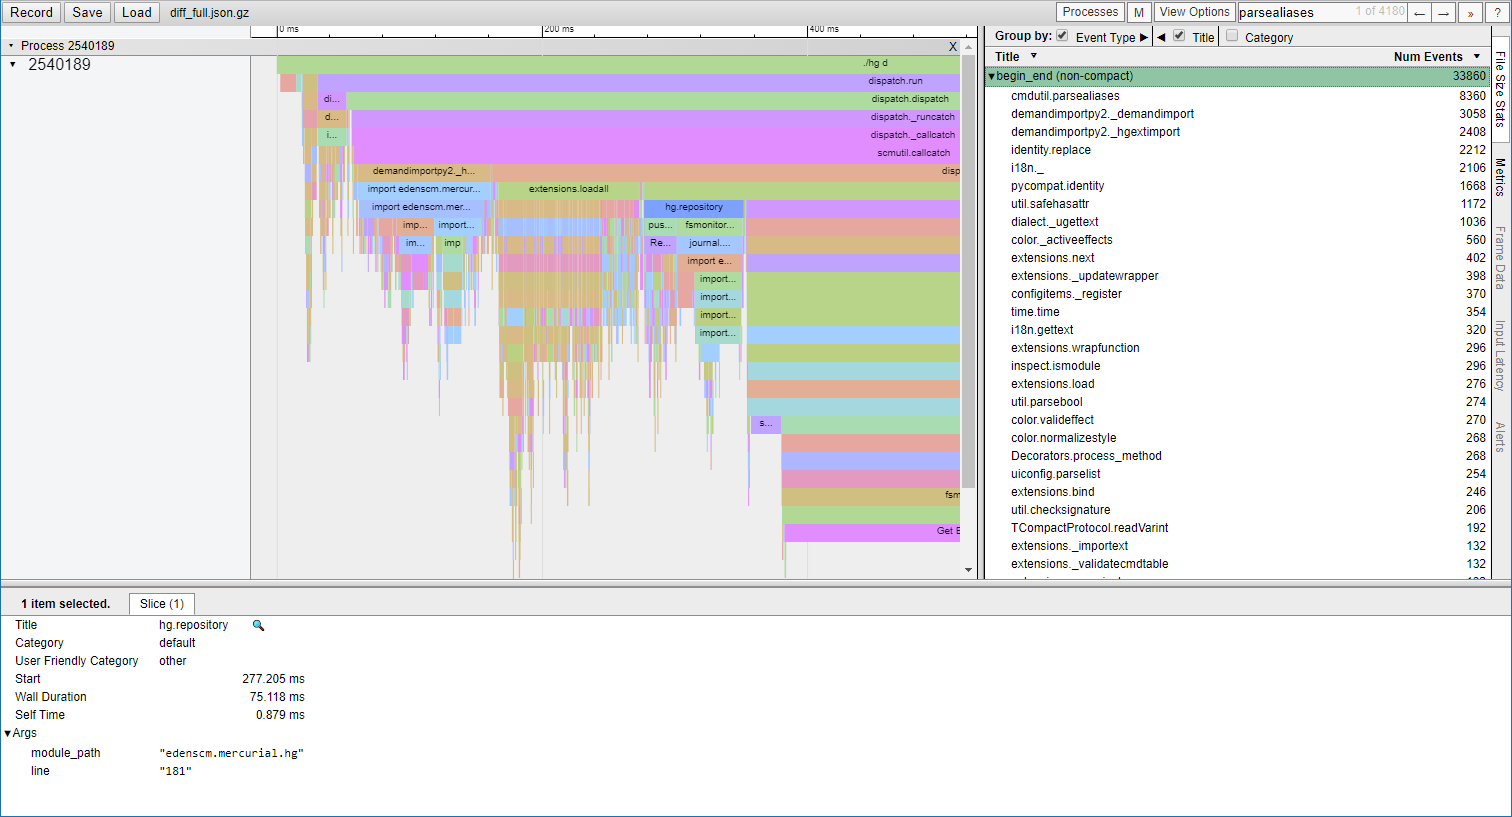

Chrome DevTools -> Performance.

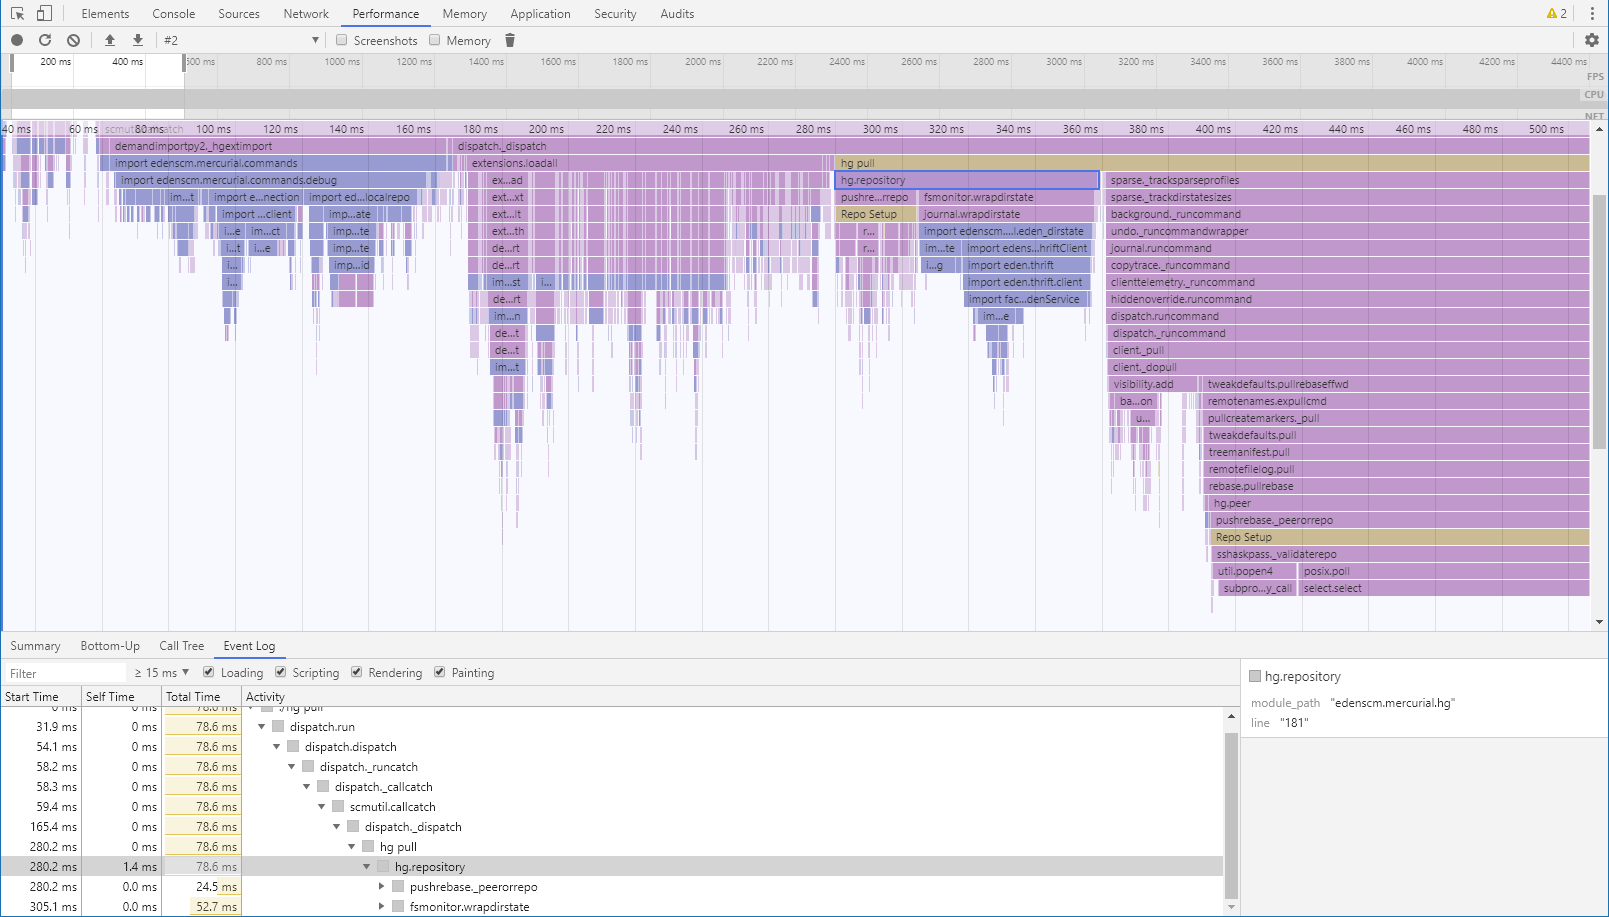

## Exporting Tracing Data

Single command. Use `EDENSCM_TRACE_OUTPUT`:

```bash
export CHGDISABLE=1
EDENSCM_TRACE_OUTPUT=a.txt     ./hg ...
EDENSCM_TRACE_OUTPUT=a.json    ./hg ...
EDENSCM_TRACE_OUTPUT=a.json.gz EDENSCM_TRACE_PY='import edenscm.*' EDENSCM_TRACE_LEVEL=debug ./hg ...
```

Traces are also logged in blackbox. Use `hg dump-trace` to merge and export them:

```bash
hg dump-trace -o a.json.gz -t 'since 15 minutes ago'
```

## Tracing for Better Testing

Examples:

- Expect a template rendering function to be called N times, under another function. How can I test it?
- Expect a network fetch function to *not* fetch `foo/bar`. How can I test it?

Today, in `.t` tests:

```
  $ hg show X --debug
  ...
  12 files fetched over 1 fetches - (12 misses, 0.00% hit ratio) over 0.00s
```

In Python tests:

```python
t = tracing.tracingdata()
with t:
    sh % "hg amend"  # code to test

assert t.treespans() ... # check spans
```

In Rust:

```rust
let data = Arc::new(Mutex::new(TracingData::new()));
let collector = TracingCollector::new(data.clone(), Level::DEBUG);

tracing::subscriber::with_default(collector, || {
    ... // code to test
});

data.lock().tree_spans();  // check spans
```

## Goodies

### Date Parsing

`lib/hgtime`:

- Compatible with formats specified by `hg help dates`.
- Support `... ago` human-readable formats.

Examples:

```rust
let time1 = hgtime::HgTime::parse("Oct 1");
let time2 = hgtime::HgTime::parse("5 minutes ago");
let time_range1 = hgtime::HgTime::parse("since 10m ago");
let time_range2 = hgtime::HgTime::parse("Oct 1 to Oct 2");
let time_range3 = hgtime::HgTime::parse("Apr 2019");  // Apr 1, 2019 to Apr 30, 2019
```

### Mincode: Fast, Compat Serde Serialization

`lib/mincode`

- Similar to bincode. But uses VLQ for integers to save spaces.
- Compact and fast. Suitable for stable structures. See D17087352 for benchmark.
- If you consider `serde_cbor::ser::to_*_packed` to reduce size, most likely `mincode` is a better choice.
- @wez has also reinvented the same thing as `varbincode`.

### Convert serde values to Python objects

`lib/cpython-ext`

Anything that implements `serde::Serialize` can be converted to Python objects trivially and efficiently.

```rust
let mut map = HashMap::<u32, u32>::new();  // Invalid JSON 
map.insert(1, 2);

let obj = cpython_ext::ser::to_object(py, &map)?;
```

### Rust Subcommands

`lib/hgcommands`

Register using `-` in command names:

```rust
table.register(foo_bar, "foo-bar", "...");
```

Supported syntax:

- `hg foo-bar`
- `hg foo --bar`
- `hg foo bar` (if `hg foo` is not a command)

Also works for aliases. 

Potential goal: move hacky flags away from main commands. For example, `diff --since-last-arc-diff`, and `amend --fixup`.

### Tracing non-hg programs

`hg debugpython --trace 'edenscm.*' python-script.py` can be used to do ad-hoc analysis.

## Future Plans

- Rage: Upload traces. Links to visualizers.
- Scuba: Upload both ASCII and Chrome traces.  Links to visualizers.
- Telemetry: Calculate derived data from blackbox in background.

## You can help!

- Set up Rust tracing.
- Add missing perftrace spans.
- Write test assertions using tracing spans.
- Look at the profiling result and fix low-hanging fruits.


<center><h3>Demo / QA</h3></center>